https://towardsdatascience.com/neural-network-calibration-using-pytorch-c44b7221a61

# Introduction

This notebooks deeply delves into exploration of neural network uncertaincy. It shows how networks tend to be overconfident and how we can resolve these issues by well known methods like Temperature Scaling. For further study I recommend looking into [this](https://arxiv.org/pdf/1706.04599.pdf) paper intuitively explaining the backgrounds.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Use the GPU provided by Google Colab
device = 'cuda:0'

# Allow reproducability
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# Normalize the images by the imagenet mean/std since the nets are pretrained
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_set, val_set = torch.utils.data.random_split(dataset, [45000, 5000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,
                                          shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=128,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128,
                                         shuffle=False, num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torchvision.models as models
import torch.nn as nn
num_classes = 10
net = models.resnet101(pretrained=True)
net.fc = nn.Linear(2048, num_classes)
net = net.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
#@title Training loop
import torch.optim as optim
from tqdm.notebook import tqdm as tqdm

NUM_EPOCHS = 2

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()
    print(f'Training iteration {epoch}')
    for i, data in enumerate(tqdm(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

    corrects = []
    net.eval()
    classified_right = 0
    print('Evaluating on validation set')
    for i, data in enumerate(tqdm(val_loader, 0)):
        with torch.no_grad():
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs = net(inputs)
          _, pred_classes = torch.max(outputs, 1)

          loss = criterion(outputs, labels)
          classified_right += (pred_classes == labels).sum().item()
          
    acc = classified_right / len(val_set)

    print(f'Epoch {epoch}  Acc: {acc}')


Training iteration 0


  0%|          | 0/352 [00:00<?, ?it/s]

Evaluating on validation set


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0  Acc: 0.799
Training iteration 1


  0%|          | 0/352 [00:00<?, ?it/s]

Evaluating on validation set


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1  Acc: 0.8214


In [ ]:
#@title ################### Testing ######################

from tqdm.notebook import tqdm

# Use kwags for calibration method specific parameters
def test(calibration_method=None, **kwargs):
  preds = []
  labels_oneh = []
  correct = 0
  net.eval()
  with torch.no_grad():
      for data in tqdm(test_loader):
          images, labels = data[0].to('cuda:0'), data[1].to('cuda:0')

          pred = net(images)
          
          if calibration_method:
            pred = calibration_method(pred, kwargs)

          # Get softmax values for net input and resulting class predictions
          sm = nn.Softmax(dim=1)
          pred = sm(pred)

          _, predicted_cl = torch.max(pred.data, 1)
          pred = pred.cpu().detach().numpy()

          # Convert labels to one hot encoding
          label_oneh = torch.nn.functional.one_hot(labels, num_classes=num_classes)
          label_oneh = label_oneh.cpu().detach().numpy()

          preds.extend(pred)
          labels_oneh.extend(label_oneh)

          # Count correctly classified samples for accuracy
          correct += sum(predicted_cl == labels).item()

  preds = np.array(preds).flatten()
  labels_oneh = np.array(labels_oneh).flatten()

  correct_perc = correct / len(test_set)
  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct_perc))
  print(correct_perc)
  
  return preds, labels_oneh

preds, labels_oneh = test()

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 82 %
0.8236


In [ ]:
def calc_bins(preds):
  # Assign each prediction to a bin
  num_bins = 10
  bins = np.linspace(0.1, 1, num_bins)
  binned = np.digitize(preds, bins, True)

  # Save the accuracy, confidence and size of each bin
  bin_accs = np.zeros(num_bins)
  bin_confs = np.zeros(num_bins)
  bin_sizes = np.zeros(num_bins)

  for bin in range(num_bins):
    bin_sizes[bin] = len(preds[binned == bin])
    if bin_sizes[bin] > 0:
      bin_accs[bin] = (labels_oneh[binned==bin]).sum() / bin_sizes[bin]
      bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]

  return bins, binned, bin_accs, bin_confs, bin_sizes



# Visualizations and metrics

The Reliability Diagram as figured below intuitively show the relation between expected sample accuracy per bin and confidence.

$acc(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbf{1}(\hat{y}_i = y_i)$

$conf(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \hat{p}_i$

For the figure I chose $M=10$, describing the number of seperate bins where the predictions are put in their respective bin based on their magnitude ($Bin 1 = [0.0, 0.1), Bin 2 = [0.1, 0.2), ...)$).

For a perfectly calibrated model is defined as $P(\hat{Y} = Y | \hat{P} = p) = p, \forall p \in [0, 1]$. For Example: Given 100 predictions, each with confidence of 0.8, we expect 80 to be correctly classified. Bars under the identity line show underconfident behavior while bars above it signal overconfidence.


The Expected Calibration Error (ECE) is taking the weighted average of the bins' accuracy/cofidence differences.

$ECE = \sum_{m=1}^{M} \frac{|B_m|}{n} |acc(B_m) - conf(B_m)|$

The Maximum Calibration Error (MCE) focuses more on high risk applications where the maximum accuracy/confidence difference is more important than just the average.

$MCE = \max_m |acc(B_m) - conf(B_m)|$

In [ ]:
def get_metrics(preds):
  ECE = 0
  MCE = 0
  bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds)

  for i in range(len(bins)):
    abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
    ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
    MCE = max(MCE, abs_conf_dif)

  return ECE, MCE

In [ ]:
import matplotlib.patches as mpatches

def draw_reliability_graph(preds):
  ECE, MCE = get_metrics(preds)
  bins, _, bin_accs, _, _ = calc_bins(preds)

  fig = plt.figure(figsize=(8, 8))
  ax = fig.gca()

  # x/y limits
  ax.set_xlim(0, 1.05)
  ax.set_ylim(0, 1)

  # x/y labels
  plt.xlabel('Confidence')
  plt.ylabel('Accuracy')

  # Create grid
  ax.set_axisbelow(True) 
  ax.grid(color='gray', linestyle='dashed')

  # Error bars
  plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

  # Draw bars and identity line
  plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
  plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

  # Equally spaced axes
  plt.gca().set_aspect('equal', adjustable='box')

  # ECE and MCE legend
  ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
  MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
  plt.legend(handles=[ECE_patch, MCE_patch])

  #plt.show()
  
  plt.savefig('calibrated_network.png', bbox_inches='tight')

#draw_reliability_graph(preds)


In [ ]:
def T_scaling(logits, args):
  temperature = args.get('temperature', None)
  return torch.div(logits, temperature)

# Temperature Scaling

Temperature Scaling is a parametric calibration approach on the validation set using the Negative-Log-Likelihood (NLL) los. It learns a single parameter $T$ for all classes to update the confidences to $\hat{q}_i = max_k  \sigma_{SM}(z_i/T)^{(k)}$



More sample code can be found in [this](https://github.com/gpleiss/temperature_scaling) awesome GitHub repository by "gpleis".

  0%|          | 0/40 [00:00<?, ?it/s]

Final T_scaling factor: 1.16


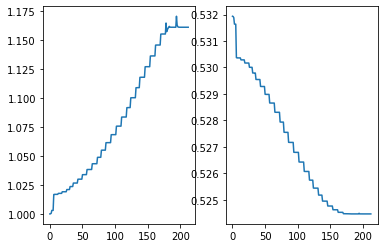

In [ ]:
temperature = nn.Parameter(torch.ones(1).cuda())
args = {'temperature': temperature}
criterion = nn.CrossEntropyLoss()

# Removing strong_wolfe line search results in jump after 50 epochs
optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

logits_list = []
labels_list = []
temps = []
losses = []

for i, data in enumerate(tqdm(val_loader, 0)):
    images, labels = data[0].to(device), data[1].to(device)

    net.eval()
    with torch.no_grad():
      logits_list.append(net(images))
      labels_list.append(labels)

# Create tensors
logits_list = torch.cat(logits_list).to(device)
labels_list = torch.cat(labels_list).to(device)

def _eval():
  loss = criterion(T_scaling(logits_list, args), labels_list)
  loss.backward()
  temps.append(temperature.item())
  losses.append(loss)
  return loss


optimizer.step(_eval)

print('Final T_scaling factor: {:.2f}'.format(temperature.item()))

plt.subplot(121)
plt.plot(list(range(len(temps))), temps)

plt.subplot(122)
xlosses = [x.detach().cpu() for x in losses]
plt.plot(list(range(len(xlosses))), xlosses)
plt.show()



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %
0.8174


  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %
0.8174


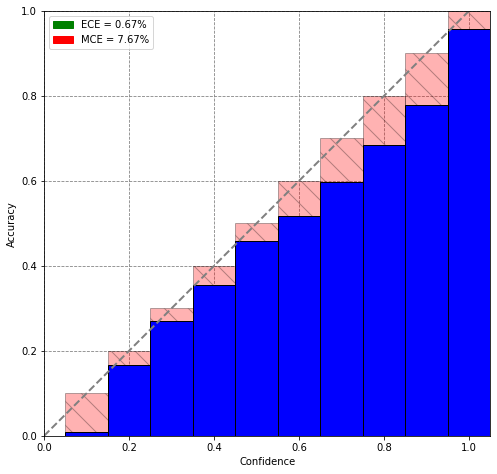

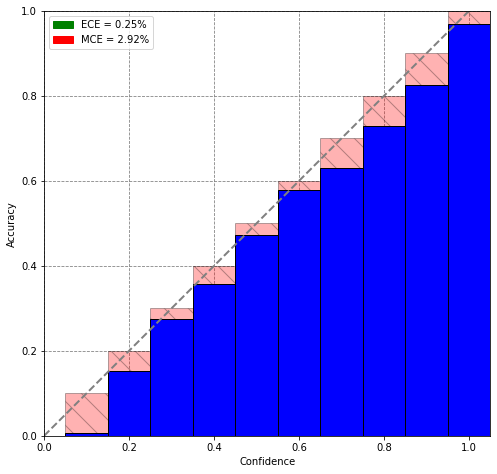

In [ ]:
preds_original, _ = test()
preds_calibrated, _ = test(T_scaling, temperature=temperature)

draw_reliability_graph(preds_original)
draw_reliability_graph(preds_calibrated)

# Epsilon-Robustness

In [ ]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.6 MB/s eta 0:00:00


In [ ]:
import art
from art.estimators.classification.pytorch import PyTorchClassifier
from art.metrics.metrics import empirical_robustness, clever_t, clever_u, clever, loss_sensitivity, wasserstein_distance

In [ ]:
#@title get min max pixel value clever score
def get_min_max_pixel_values(loader):
  minpx = np.inf
  maxpx = - np.inf
  for data in tqdm(test_loader):
    x = data[0]
    if x.min() < minpx:
        minpx = x.min()
    if x.max() > maxpx:
        maxpx = x.max()
    return minpx, maxpx

def clever_score(model, x, **args):
    classifier = PyTorchClassifier(
    model=model,
    clip_values=(args['min_pixel_value'], args['max_pixel_value']),
    loss=None,
    optimizer=None,
    input_shape=(1, 32, 32),
    nb_classes=10,
    )
    res = clever_u(classifier, x.numpy(), 
                    nb_batches=20, 
                    batch_size=1, 
                    radius=0.3, #args['radius'], 
                    norm=np.inf, #args['norm'], 
                    pool_factor=3, verbose=False)
    return res

In [ ]:
xtest_set = torch.utils.data.Subset(test_set, np.arange(100))
xtest_loader = torch.utils.data.DataLoader(xtest_set, batch_size=1,
                                         shuffle=False, num_workers=2)

In [ ]:
minpx , maxpx = get_min_max_pixel_values(test_loader)
clever_args={'min_pixel_value':  minpx, 'max_pixel_value': maxpx}
clever_scores = []
net.eval()
for data in tqdm(xtest_loader):
    clever_dis = clever_score(net, data[0][0], **clever_args)
    clever_scores.append(clever_dis)
clever_scores =  np.array(clever_scores)

(array([30., 26., 15., 12.,  7.,  5.,  3.,  0.,  0.,  2.]),
 array([0.00042445, 0.00736047, 0.01429649, 0.02123251, 0.02816853,
        0.03510455, 0.04204057, 0.04897659, 0.05591261, 0.06284864,
        0.06978466]),
 <a list of 10 Patch objects>)

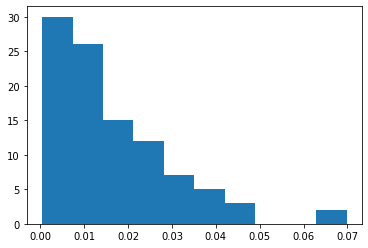

In [ ]:
counts, bins = np.histogram(clever_scores)
plt.hist(bins[:-1], bins, weights=counts)

## Adv examples

In [ ]:
!pip install cleverhans

In [ ]:
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent as pgd
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2 

In [ ]:
def compute_norm(x, norm):
    with torch.no_grad():
        if norm == np.inf:
            return torch.linalg.norm(torch.ravel(x.cpu()), ord=np.inf).numpy()
        elif norm == 2:
            return torch.linalg.norm(x.cpu()).numpy()
        else:
            raise NotImplementedError

def compute_entropy(probs):
    log_probs = np.log(probs)
    p_log_p = log_probs * probs
    entropy = -np.nansum(p_log_p)
    return entropy

In [ ]:
def calc_entropy(probs):
    log_probs = np.log(probs)
    p_log_p = log_probs * probs
    entropy = -np.nansum(p_log_p)
    return entropy
calc_entropy(preds[:10])

0.18112671

In [ ]:
a = np.array([0.5,0.5])
compute_entropy(torch.tensor(a))

0.6931471805599453

In [ ]:
#@title adv test
pgd_params = {'eps': 0.3, 'eps_iter': 0.005, 'nb_iter': 100, 'norm': np.inf, 'targeted': False, 'rand_init': True, 'rand_minmax': 0.1}
cw_params = {' n_classes':10, 'targeted': False}


def adv_test(calibration_method=None, **kwargs):
  preds = []
  labels_oneh = []
  distances = []
  clever_scores = []
  entropies = []

  correct = 0
  net.eval()
  with torch.no_grad():
      for data in tqdm(xtest_loader):
          images, labels = data[0].to('cuda:0'), data[1].to('cuda:0')
          with torch.enable_grad():
            x_adv = pgd(net, images, **pgd_params).detach()
          pred = net(x_adv)
          
          distances.append(compute_norm((x_adv-images), np.inf))
          with torch.enable_grad():
            clever_dis = clever_score(net, x_adv[0].cpu(), **clever_args)
          clever_scores.append(clever_dis)

          if calibration_method:
            pred = calibration_method(pred, kwargs)

          # Get softmax values for net input and resulting class predictions
          sm = nn.Softmax(dim=1)
          pred = sm(pred)

          entropy = compute_entropy(pred.cpu())
          # if entropy < 0.001:
          #     print(pred.max())
          entropies.append(entropy)
  
          _, predicted_cl = torch.max(pred.data, 1)
          pred = pred.cpu().detach().numpy()

          # Convert labels to one hot encoding
          label_oneh = torch.nn.functional.one_hot(labels, num_classes=num_classes)
          label_oneh = label_oneh.cpu().detach().numpy()

          preds.extend(pred)
          labels_oneh.extend(label_oneh)

          # Count correctly classified samples for accuracy
          correct += sum(predicted_cl == labels).item()

  preds = np.array(preds).flatten()
  labels_oneh = np.array(labels_oneh).flatten()

  correct_perc = correct / len(test_set)
  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct_perc))
  print(correct_perc)
  
  return preds, labels_oneh, np.array(distances), np.array(clever_scores), np.array(entropies)

In [ ]:
# xpreds_original, _, distances = adv_test()
xpreds_calibrated, _, distances, xclever_scores, xentropies = adv_test(T_scaling, temperature=temperature)
# draw_reliability_graph(preds_original)
# draw_reliability_graph(preds_calibrated)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 0 %
0.0012


In [ ]:
distances

array([0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
       0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000

(array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., 99.]),
 array([0.30000004, 0.30000004, 0.30000004, 0.30000004, 0.30000004,
        0.30000007, 0.30000007, 0.30000007, 0.30000007, 0.30000007,
        0.30000007], dtype=float32),
 <a list of 10 Patch objects>)

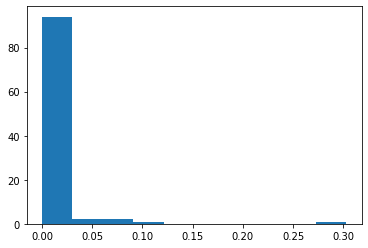

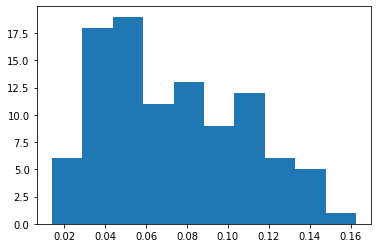

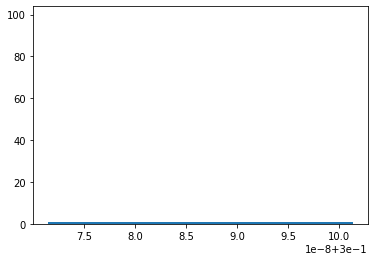

In [ ]:
counts, bins = np.histogram(xentropies)
plt.hist(bins[:-1], bins, weights=counts)
plt.figure()
counts, bins = np.histogram(xclever_scores)
plt.hist(bins[:-1], bins, weights=counts)
plt.figure()
counts, bins = np.histogram(distances)#-distances.min())/(distances.max() - distances.min()))
plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
#@title clean test xloader
pgd_params = {'eps': 0.3, 'eps_iter': 0.01, 'nb_iter': 20, 'norm': np.inf, 'targeted': False, 'rand_init': True} #, 'rand_minmax': 0.1}
cw_params = {' n_classes':10, 'targeted': False}


def clean_test(calibration_method=None, **kwargs):
  preds = []
  labels_oneh = []
  distances = []
  clever_scores = []
  entropies = []

  correct = 0
  net.eval()
  with torch.no_grad():
      for data in tqdm(xtest_loader):
          images, labels = data[0].to('cuda:0'), data[1].to('cuda:0')

          pred = net(images)
          
          distances.append(compute_norm(images-images, np.inf))
          with torch.enable_grad():
            clever_dis = clever_score(net, images[0].cpu(), **clever_args)
          clever_scores.append(clever_dis)

          if calibration_method:
            pred = calibration_method(pred, kwargs)

          # Get softmax values for net input and resulting class predictions
          sm = nn.Softmax(dim=1)
          pred = sm(pred)

          entropy = compute_entropy(pred.cpu())
          # if entropy < 0.001:
          #     print(pred.max())
          entropies.append(entropy)
  
          _, predicted_cl = torch.max(pred.data, 1)
          pred = pred.cpu().detach().numpy()

          # Convert labels to one hot encoding
          label_oneh = torch.nn.functional.one_hot(labels, num_classes=num_classes)
          label_oneh = label_oneh.cpu().detach().numpy()

          preds.extend(pred)
          labels_oneh.extend(label_oneh)

          # Count correctly classified samples for accuracy
          correct += sum(predicted_cl == labels).item()

  preds = np.array(preds).flatten()
  labels_oneh = np.array(labels_oneh).flatten()

  correct_perc = correct / len(test_set)
  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct_perc))
  print(correct_perc)
  
  return preds, labels_oneh, np.array(distances), np.array(clever_scores), np.array(entropies)

In [ ]:
cpreds_calibrated, _, cdistances, cclever_scores, centropies = clean_test(T_scaling, temperature=temperature)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 0 %
0.0081


(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <a list of 10 Patch objects>)

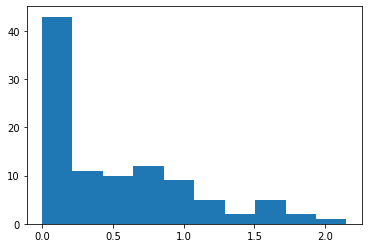

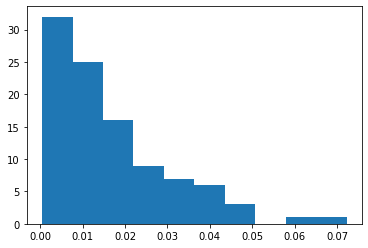

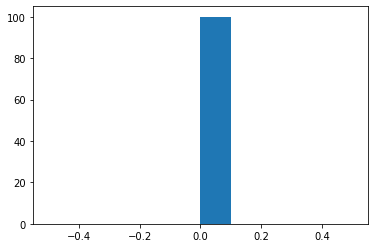

In [ ]:
counts, bins = np.histogram(centropies)
plt.hist(bins[:-1], bins, weights=counts)
plt.figure()
counts, bins = np.histogram(cclever_scores)
plt.hist(bins[:-1], bins, weights=counts)
plt.figure()
counts, bins = np.histogram((cdistances))#-distances.min())/(distances.max() - distances.min()))
plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
#@title draft
# pgd_params = {'eps': 0.3, 'eps_iter': 0.01, 'nb_iter': 20, 'norm': np.inf, 'targeted': False, 'rand_init': True} #, 'rand_minmax': 0.1}
# cw_params = {' n_classes':10, 'targeted': False}

# preds = []
# labels_oneh = []
# correct = 0
# net.eval()
# with torch.no_grad():
#     for data in tqdm(test_loader):
#         images, labels = data[0].to('cuda:0'), data[1].to('cuda:0')
#         with torch.enable_grad():
#           x_adv = pgd(net, images, **pgd_params)
#         pred = net(x_adv)

#         # Get softmax values for net input and resulting class predictions
#         sm = nn.Softmax(dim=1)
#         pred = sm(pred)

#         _, predicted_cl = torch.max(pred.data, 1)
#         pred = pred.cpu().detach().numpy()

#         # Convert labels to one hot encoding
#         label_oneh = torch.nn.functional.one_hot(labels, num_classes=num_classes)
#         label_oneh = label_oneh.cpu().detach().numpy()

#         preds.extend(pred)
#         labels_oneh.extend(label_oneh)

#         # Count correctly classified samples for accuracy
#         correct += sum(predicted_cl == labels).item()
#         break 
# preds = np.array(preds).flatten()
# labels_oneh = np.array(labels_oneh).flatten()

# correct_perc = correct / len(test_set)
# print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct_perc))
# print(correct_perc)

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 0 %
0.0012
